In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [20]:
df = pd.read_csv('otto-group-product-classification-challenge/train.csv')  # Update file path

# Preprocess data
# Separate features and target
X = df.drop(columns=['id', 'target'])  # Exclude 'id' and 'target'
y = df['target']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

[0 0 0 ... 8 8 8]


Missing values:
 id         0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
          ..
feat_90    0
feat_91    0
feat_92    0
feat_93    0
target     0
Length: 95, dtype: int64


C:\Users\Vishnu Teja\AppData\Local\Temp\ipykernel_29300\2859764326.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='target', palette='viridis')


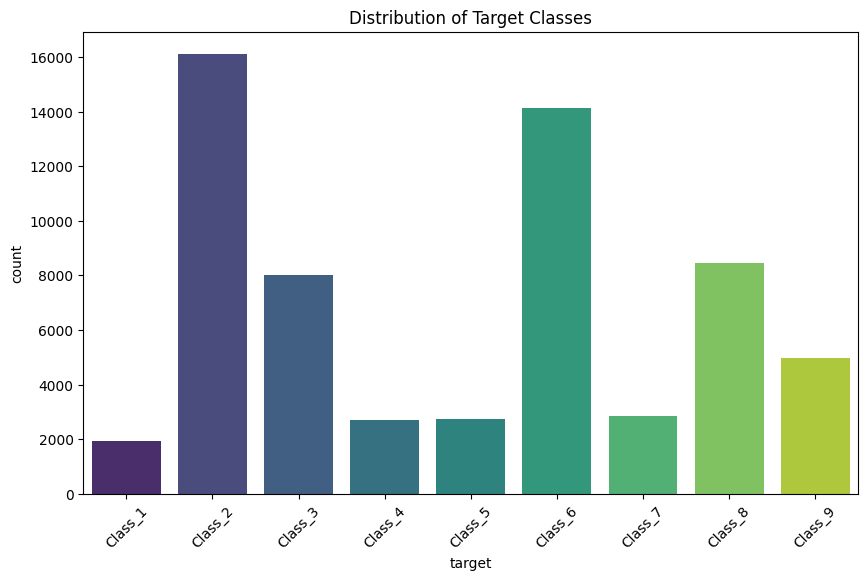

In [21]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing)

# Target variable distribution
if 'target' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='target', palette='viridis')
    plt.title('Distribution of Target Classes')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Target column not found in the dataset!")

# Pairplot for feature relationships (Optional)
# Uncomment below if your dataset is small or you limit features
# sample_df = df.sample(1000)  # Use a smaller subset for visualization
# sns.pairplot(sample_df, hue='target', palette='husl')
# plt.show()



In [22]:
class OttoDataset(Dataset):
    def __init__(self, features, labels, device):
        self.features = torch.tensor(features, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.long).to(device)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets and data loaders
train_dataset = OttoDataset(X_train, y_train, device)
test_dataset = OttoDataset(X_test, y_test, device)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
## Step 4: Define the Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model and move it to the appropriate device
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = NeuralNet(input_size, num_classes).to(device)

## Step 5: Set Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
## Step 6: Train the Model
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for features, labels in train_loader:
        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.6858
Epoch [2/20], Loss: 0.5585
Epoch [3/20], Loss: 0.5281
Epoch [4/20], Loss: 0.5051
Epoch [5/20], Loss: 0.4899
Epoch [6/20], Loss: 0.4743
Epoch [7/20], Loss: 0.4595
Epoch [8/20], Loss: 0.4503
Epoch [9/20], Loss: 0.4387
Epoch [10/20], Loss: 0.4262
Epoch [11/20], Loss: 0.4176
Epoch [12/20], Loss: 0.4076
Epoch [13/20], Loss: 0.3998
Epoch [14/20], Loss: 0.3908
Epoch [15/20], Loss: 0.3847
Epoch [16/20], Loss: 0.3760
Epoch [17/20], Loss: 0.3700
Epoch [18/20], Loss: 0.3639
Epoch [19/20], Loss: 0.3568
Epoch [20/20], Loss: 0.3530


Test Accuracy: 0.8064
Classification Report:
              precision    recall  f1-score   support

     Class_1       0.69      0.54      0.60       386
     Class_2       0.71      0.87      0.78      3224
     Class_3       0.62      0.46      0.53      1601
     Class_4       0.78      0.44      0.56       538
     Class_5       0.98      0.97      0.98       548
     Class_6       0.94      0.94      0.94      2827
     Class_7       0.73      0.64      0.68       568
     Class_8       0.93      0.91      0.92      1693
     Class_9       0.82      0.89      0.86       991

    accuracy                           0.81     12376
   macro avg       0.80      0.74      0.76     12376
weighted avg       0.80      0.81      0.80     12376



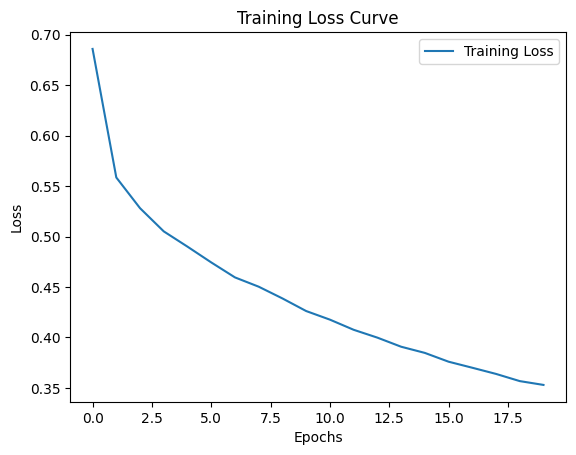

In [25]:
## Step 7: Evaluate the Model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU
        all_labels.extend(labels.cpu().numpy())  # Move labels to CPU

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

## Step 8: Plot Training Loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()
